## Cuckoo Search

This class represents standard Cuckoo Search based on the explanation in the [\[book\]](https://doi.org/10.1016/B978-0-12-416743-8.00009-9) Nature-Inspired Optimization Algorithms by Xin-She Yang and his implementation of standard Cuckoo Search in Matlab on [\[mathworks\]](https://www.mathworks.com/matlabcentral/fileexchange/29809-cuckoo-search-cs-algorithm). The implementation is slightly different to the flow of the algorithm described in the book. The figures below describe the pseudocode of the algorithm from the book, and the flow of the implementation. The GRW stands for Global Random Walk by Levy Flight, and the LRW stands for Local Random Walk.

1) **Initial Population:**: A starting population is sampled in the beginning. In this framework, this can be either a [Sampling](../operators/sampling.ipynb) object, which defines different initial sampling strategies, or `Population` where the `X` and `F` values are set, or a simple NumPy array (pop_size x n_var).

2) **Evaluation:** It is executed using the problem defined to be solved.

3) **Survival:** The survival mechanism used is by default the survival of the fittest for the Elitism.

4) **Global Random Walk:** The global random walks use a step size that is generated based on Levy Flight Distribution. Every dimension will have its own randomly generated step size on every operation. The Global Random Walk can be done following the book which to randomly choose solution $x_{i}$ which will be modified by Global Random Walk resulting in $x'_i$ and replace a randomly chosen solution $x_{j}$, if $x'_{i}$ is better than $x_{j}$. However for simplicity sake, as also been done in the matlab implementation, $x'_{i}$ will be compared to $x_{i}, \forall i$ in every iteration. 

5) **Local Random Walk:** After the Global Random Walk has been done, including the replacement after improvement, every nest $x_i$ has a $p_a$ probability to create new solution via Local Ranom Walk $x'_i = x_i + \alpha_0*(x_j-x_k)$ with $x_j$ and $x_k$ are two different randomly selected nest. Afterwards, combine the old nests with the new generated nests via Local Random Walks. The size of the combined nests will be pop_size $\leq$ combined_pop_size $\leq 2$pop_size. Survival mechanism thus will be used to select a number of pop_size best nests.



<div style="display: block;margin-left: auto;margin-right: auto;width: 60%;">
![cs_pseudocode](../resources/images/cuckoo_search_pseudocode.png)
</div>

<div style="display: block;margin-left: auto;margin-right: auto;width: 60%;">
![cs_flow](../resources/images/cuckoo_search_flow.png)
</div>

### Example

In [52]:
import numpy as np
from scipy.spatial.distance import cdist

from pymoo.algorithms.so_cuckoo_search import MantegnasAlgorithm
from pymoo.algorithms.genetic_algorithm import GeneticAlgorithm
from pymoo.decomposition.tchebicheff import Tchebicheff2
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.model.infill import InfillCriterion
from pymoo.factory import get_decomposition
from pymoo.model.individual import Individual
from pymoo.model.population import Population
from pymoo.operators.crossover.simulated_binary_crossover import SimulatedBinaryCrossover
from pymoo.operators.mutation.polynomial_mutation import PolynomialMutation
from pymoo.operators.sampling.random_sampling import FloatRandomSampling
from pymoo.util.display import MultiObjectiveDisplay
from pymoo.util.misc import set_if_none
from pymoo.operators.repair.to_bound import set_to_bounds_if_outside_by_problem




# =========================================================================================================
# Implementation
# =========================================================================================================
class Modified_RW(InfillCriterion):

    def __init__(self, alpha, beta, pa, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.levy = MantegnasAlgorithm(beta)
        self.mutation = PolynomialMutation(prob=None, eta=20)
        self.pa = pa        
        
     #E is the neighbourhood in the form of indexes
    #i is the current solution to be modified
    def _grw(self, problem,  pop, E, i):
        #choose 1 random solution index from E        
        X = pop.get("X")
        r1 = np.random.choice(E, 1)[0]
        dvec = self.alpha*(X[r1] - X[i])*self.levy.do(problem.n_var)
        _x = X[i] + dvec
        _x = set_to_bounds_if_outside_by_problem(problem, _x[None, :])
        
        off = Population.new(X=_x)
        off = self.mutation.do(problem, off)
        return off
    
    def _lrw(self, problem, pop, E, i):
        r1, r2 = np.random.choice(E, 2, replace=False)
        X = pop.get("X")
        
        eps = np.random.rand()
        dvec = eps*(X[r1]-X[r2])
        if np.random.rand() > self.pa:
            dvec = 0
        _x = X[i] + dvec
        _x = set_to_bounds_if_outside_by_problem(problem, _x[None, :])
        
        off = Population.new(X=_x)
        return off

    def _do(self, problem, pop, n_offsprings, parents=None, **kwargs):        
        if parents is None:
            raise Exception("parents cannot be None, must be [Neighbors, idx, op]")
        neighbors, idx, op = parents
        if op==0:
            off = self._grw(problem, pop, neighbors, idx)
        else:
            off = self._lrw(problem, pop, neighbors, idx)
        return off

       

class MOEAD_CS(GeneticAlgorithm):

    def __init__(self,
                 ref_dirs,                             
                 alpha=1,
                 beta=1.5,
                 c=5,
                 n_replacement=2,
                 n_neighbors=None,
                 decomposition=Tchebicheff2(),
                 pa=0.25,
                 prob_neighbor_mating=0.9,
                 display=MultiObjectiveDisplay(),
                 **kwargs):
        """

        MOEAD_CS Algorithm.

        Parameters
        ----------
        ref_dirs
        n_neighbors
        decomposition
        prob_neighbor_mating
        display
        kwargs
        """
        set_if_none(kwargs, 'pop_size', len(ref_dirs))
        set_if_none(kwargs, 'sampling', FloatRandomSampling())
        set_if_none(kwargs, 'survival', None)
        set_if_none(kwargs, 'selection', None)

        mating = Modified_RW(alpha=alpha, beta=beta, pa=pa)
        super().__init__(display=display, mating=mating, **kwargs)
        
        self.nds = NonDominatedSorting()
        self.ref_dirs = ref_dirs
        self.n_neighbors = n_neighbors
        if self.n_neighbors is None:
            self.n_neighbors = int(self.pop_size/10)
        self.n_replacement = n_replacementL
        self.prob_neighbor_mating = prob_neighbor_mating
        self.decomposition = decomposition
        self.alpha = alpha
        self.levy = MantegnasAlgorithm(beta)
        
        #parameters for adaptive operators
        self.c = c
        self.W = int(self.pop_size/2)
        self.used_op = np.full(self.W, -1)
        self.op_rewards = np.full(self.W, 0)
        self.sw_idx = 0
        
        # neighbours includes the entry by itself intentionally for the survival method
        self.neighbors = np.argsort(cdist(self.ref_dirs, self.ref_dirs), axis=1, kind='quicksort')
        self.neighbors = self.neighbors[:, :self.n_neighbors]

    def _initialize(self):
        if isinstance(self.decomposition, str):
            decomp = self.decomposition
            self._decomposition = get_decomposition(decomp)
        else:
            self._decomposition = self.decomposition

        #init population and save ideal & nadir point
        super()._initialize()
        self.ideal_point = np.min(self.pop.get("F"), axis=0)
        pf = self.nds.do(self.pop.get("F"), only_non_dominated_front=True)
        self.nadir_point = np.max(pf, axis=0)
        max_angles = self._calc_max_angle(self.ref_dirs, self.pop.get("F"))
        self.pop.set("max_angle", max_angles)
        
    def _calc_max_angle(self, w, F):
        f = F-self.ideal_point
        cos = np.dot(f, w.T) / np.dot(np.linalg.norm(f, axis=1), np.linalg.norm(w, axis=1))
        angles = np.arccos(cos)
        return np.max(angles, axis=1)
        
    #operator index : 0->Global Random Walk 1->Local Random Walk
    def _calc_op_score(self, FRR, op_freq):
        op_freq_ratio = self.c + np.sqrt(2*np.log(np.sum(op_freq))/op_freq)
        score = FRR + op_freq_ratio
        return score
    
    def _choose_op(self):
        I_op = [self.used_op == 0, self.used_op == 1]
        op_freq = np.array([len(self.used_op[I_op[0]]), len(self.used_op[I_op[1]])])
        #if there is an unused operator then randomly pick from the two
        if op_freq[0]==0 or op_freq[1]==0:
            return np.random.randint(2)
        reward0 = np.sum(self.op_rewards[I_op[0]])
        reward1 = np.sum(self.op_rewards[I_op[1]])
        tot_rewards = np.sum(self.op_rewards)
        FRR = np.array([reward0, reward1])
        op_score = self._calc_op_score(FRR, op_freq)
        return np.argmin(op_score)
    
    def _next(self):
        op = self._choose_op()
        for idx in range(self.pop_size):
            if np.random.rand() <= self.prob_neighbor_mating:
                E = self.neighbors[idx]            
            else:
                E = np.arange(self.pop_size)                    

            parents = np.array([E, idx, op], dtype='object')
            off = self.mating.do(self.problem, self.pop, 1, parents=parents, algorithm=self)
            self.evaluator.eval(self.problem, off)
            
            self.ideal_point = np.min(np.vstack([self.ideal_point, off.get("F")]), axis=0)

            max_angles_old = self.pop.get("max_angle")[E]
            w = self.ref_dirs[E]
            f = np.tile(off.get("F"), (len(E), 1))
            max_angles_new = self._calc_max_angle(w, f)

            FV = self._decomposition.do(self.pop[E].get("F"), weights=self.ref_dirs[E], ideal_point=self.ideal_point)
            off_FV = self._decomposition.do(f, weights=self.ref_dirs[E], ideal_point=self.ideal_point)

            #update solutions by off
            #if tch score improved  and in max angle area of the current solution
            index_permut = np.random.permutation(len(E))
            FIR = 0
            nr  = 0
            for jdx in index_permut:
                g = (FV[jdx] - off_FV[jdx])/FV[jdx]
                dt = max_angles_old[jdx] - max_angles_new[jdx]

                if g>=0 and dt>=0:
                    self.pop[E[jdx]] = off[0]
                    self.pop[E[jdx]].set("max_angle", max_angles_new[jdx])
                    FIR += g
                    nr += 1
                    if nr == self.n_replacement:
                        break

            #record used operator and the reward (improvement rate) obtained 
            self.op_rewards[self.sw_idx] = FIR
            self.used_op[self.sw_idx] = op
            self.sw_idx = (self.sw_idx+1) % self.W

        #update nadir point
        pf = self.nds.do(self.pop.get("F"), only_non_dominated_front=True)
        self.nadir_point = np.max(pf, axis=0)

        #update max angles
        max_angles = self._calc_max_angle(self.ref_dirs, self.pop.get("F"))
        self.pop.set("max_angle", max_angles)
               
# parse_doc_string(MOEAD.__init__)


50.57150053977966


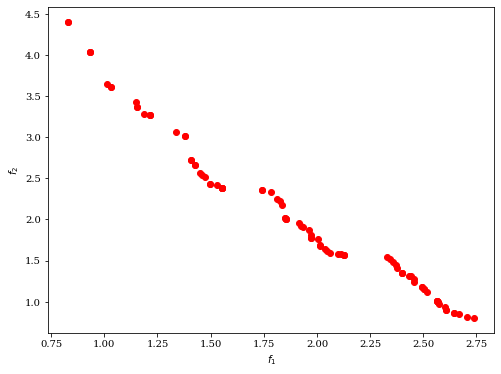

In [59]:
from pymoo.factory import get_problem, get_visualization, get_reference_directions
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

problem = get_problem("wfg1", n_var=8, n_obj=2)
n_obj = 2
ref_dirs = get_reference_directions("das-dennis", n_obj, n_partitions=99)
algorithm = MOEAD_CS(ref_dirs=ref_dirs)
res = minimize(problem, algorithm, termination=('n_eval', 25000))
print(res.exec_time)
if n_obj == 2:
    plot = Scatter()
    plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
    plot.add(res.F, color="red")
    plot.show()
else:
    plot = Scatter().add(res.F)
    plot.show()

### API

In [31]:
import numpy as np
A = np.array([1,2,3,1,2,3,1,1,1])
print(A==1)
print(A[A==1])

[ True False False  True False False  True  True  True]
[1 1 1 1 1]
